In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
import numpy as np
import pathlib
import matplotlib.pyplot as plt

In [2]:
data_root_orig = tf.keras.utils.get_file(origin='https://commondatastorage.googleapis.com/books1000/notMNIST_small.tar.gz',
                                         fname='notMNIST_small', untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

/home/maxim/.keras/datasets/notMNIST_small


Загрузим датасет

In [3]:
VALIDATION_SET_RATE = 0.05

# define image generators for train, validation and test set
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SET_RATE
)
image_generator

Преобразуем изображения в flow при помощи ImageDataGenerator.

In [4]:
BATCH_SIZE = 32
IMG_HEIGHT = 28
IMG_WIDTH = 28
IMG_CHANNELS = 3
EPOCHS_COUNT = 10



train_data_gen = image_generator.flow_from_directory(directory=str(data_root),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     subset='training')
STEPS_PER_EPOCH_TRAIN = np.ceil(train_data_gen.samples/BATCH_SIZE)

validation_data_gen = image_generator.flow_from_directory(directory=str(data_root),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     subset='validation')

STEPS_PER_EPOCH_VALIDATION = np.ceil(validation_data_gen.samples/BATCH_SIZE)

Found 17794 images belonging to 10 classes.
Found 930 images belonging to 10 classes.


In [5]:
def load_image(filename, image_size):
    w, h = image_size
    # load the image
    img = load_img(filename, target_size=(w, h))
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 3 channels
    img = img.reshape(1, w, h, 3)
    # center pixel data
    img = img.astype('float32')
    return img

Определим свёрточную нейронную сеть с 2мя свёрточными слоями и 1 полносвязным слоем.

In [6]:
# Define 1 input 2 conv and 1 fc layer with softmax output
input_layer = layers.Input(
    shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
    name='input'
)

conv_1 = layers.Conv2D(
    filters=16,
    kernel_size=(3, 3),
    strides=(1,1),
    padding='same',
    activation='relu',
    name='conv_1'
)

conv_2 = layers.Conv2D(
    filters=40,
    kernel_size=(3, 3),
    strides=(1,1),
    padding='same',
    activation='relu',
    name='conv_2'
)

fc_1 = layers.Dense(128, activation='relu', name='fc_1')
out = layers.Dense(10, activation='softmax', name='output')

two_conv_model = keras.Sequential([
    input_layer,
    conv_1,
    conv_2,
    layers.Flatten(),
    fc_1,
    out
])
two_conv_model.summary()

# compile the model
two_conv_model.compile(
    optimizer='sgd',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 28, 28, 16)        448       
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 40)        5800      
_________________________________________________________________
flatten (Flatten)            (None, 31360)             0         
_________________________________________________________________
fc_1 (Dense)                 (None, 128)               4014208   
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 4,021,746
Trainable params: 4,021,746
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = two_conv_model.fit_generator(
    train_data_gen,
    validation_data=validation_data_gen,
    steps_per_epoch=STEPS_PER_EPOCH_TRAIN,
    validation_steps=STEPS_PER_EPOCH_VALIDATION,
    epochs=EPOCHS_COUNT
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 557.0 steps, validate for 30.0 steps
Epoch 1/10
557/557 [==============================] - 16s 29ms/step - loss: 0.5904 - accuracy: 0.8374 - val_loss: 0.4806 - val_accuracy: 0.8882
Epoch 2/10
557/557 [==============================] - 23s 42ms/step - loss: 0.3598 - accuracy: 0.8979 - val_loss: 0.4224 - val_accuracy: 0.9022
Epoch 3/10
557/557 [==============================] - 21s 39ms/step - loss: 0.3059 - accuracy: 0.9131 - val_loss: 0.4061 - val_accuracy: 0.8946
Epoch 4/10
557/557 [==============================] - 22s 39ms/step - loss: 0.2702 - accuracy: 0.9205 - val_loss: 0.3817 - val_accuracy: 0.9011
Epoch 5/10
557/557 [==============================] - 22s 39ms/step - loss: 0.2405 - accuracy: 0.9292 - val_loss: 0.3544 - val_accuracy: 0.9097
Epoch 6/10
557/557 [==============================] - 22s 39ms/step - loss: 0.2089 - accuracy: 0.9385 - val

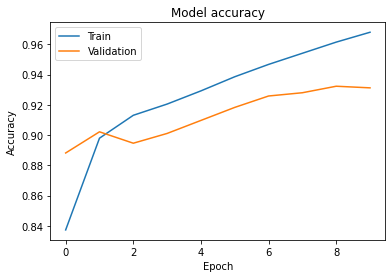

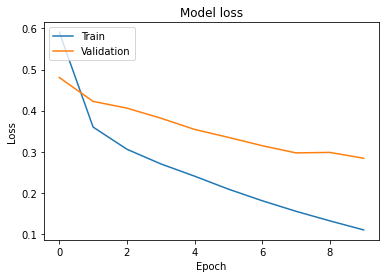

In model with 2 Conv layers max accuracy = 0.9679105


In [8]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print("In model with 2 Conv layers max accuracy = " + str(max(history.history['accuracy'])))

Как видно из графиков и процесса обучения - модель начала со временем переобучаться, однако в то же время стабильно показывает 90+ процентную точность.

Далее составим модель состояющую почти из тех же слоёв, что и раньше, но заменим один из свёрточных слоёв, слоем пулинга (а конкретно, MaxPooling'a).

In [9]:
POOL_SIZE = 2

input_layer = layers.Input(
    shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
    name='input'
)

conv_1 = layers.Conv2D(
    filters=16,
    kernel_size=(3, 3),
    strides=(1,1),
    padding='same',
    activation='relu',
    name='conv_1'
)

conv_2 = layers.Conv2D(
    filters=40,
    kernel_size=(3, 3),
    strides=(1,1),
    padding='same',
    activation='relu',
    name='conv_2'
)

fc_1 = layers.Dense(128, activation='relu', name='fc_1')
out = layers.Dense(10, activation='softmax', name='output')

pool_1 = layers.MaxPooling2D(
    pool_size=POOL_SIZE,
    name='pool_1'
)

model_with_pooling = keras.Sequential([
    input_layer,
    conv_1,
    pool_1,
    layers.Flatten(),
    fc_1,
    out
])

model_with_pooling.summary()
model_with_pooling.compile(
    optimizer='sgd',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 28, 28, 16)        448       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 14, 14, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
fc_1 (Dense)                 (None, 128)               401536    
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 403,274
Trainable params: 403,274
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model_with_pooling.fit_generator(
    train_data_gen,
    validation_data=validation_data_gen,
    steps_per_epoch=STEPS_PER_EPOCH_TRAIN,
    validation_steps=STEPS_PER_EPOCH_VALIDATION,
    epochs=EPOCHS_COUNT
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 557.0 steps, validate for 30.0 steps
Epoch 1/10
557/557 [==============================] - 8s 14ms/step - loss: 0.6151 - accuracy: 0.8333 - val_loss: 0.5041 - val_accuracy: 0.8785
Epoch 2/10
557/557 [==============================] - 7s 13ms/step - loss: 0.3758 - accuracy: 0.8942 - val_loss: 0.4417 - val_accuracy: 0.9000
Epoch 3/10
557/557 [==============================] - 8s 14ms/step - loss: 0.3350 - accuracy: 0.9042 - val_loss: 0.4216 - val_accuracy: 0.8968
Epoch 4/10
557/557 [==============================] - 7s 13ms/step - loss: 0.3038 - accuracy: 0.9123 - val_loss: 0.4206 - val_accuracy: 0.9000
Epoch 5/10
557/557 [==============================] - 7s 13ms/step - loss: 0.2834 - accuracy: 0.9200 - val_loss: 0.3987 - val_accuracy: 0.8957
Epoch 6/10
557/557 [==============================] - 7s 13ms/step - loss: 0.2640 - accuracy: 0.9233 - val_loss: 0.3849 - val_accuracy: 0.8957
Epoch 7/10
557/557 [=========================

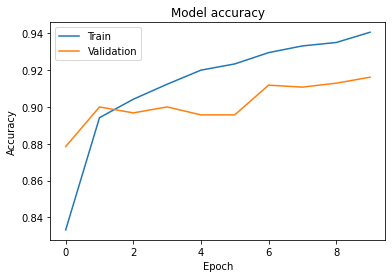

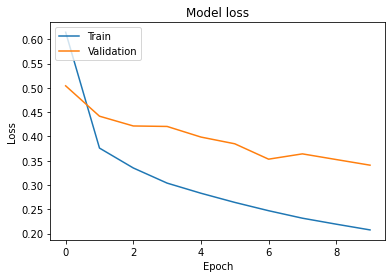

In model with 1 Conv layer and 1 Pooling layer max accuracy = 0.94054174


In [11]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print("In model with 1 Conv layer and 1 Pooling layer max accuracy = " + str(max(history.history['accuracy'])))

Как видно из графиков и значений - данная модель также хорошо себя показывает, однако с меньшими значениями точности на обучающей выборке. Однако в то же время, как видно из графиков, данная модель медленнее обучается и в то же время - у неё меньшее значение переобучения.

Следующим реализуем модель LeNet-5. (состоит из 3х "слоёв" и 1 полносвязного слоя, каждый "слой" представляет собой связку свёртка-пулинг).

In [12]:
# Lets define classic LeNet-5 architecture

conv_lenet_1 = layers.Conv2D(
    filters=6,
    kernel_size=(3, 3),
    strides=(1,1),
    padding='valid',
    activation='tanh',
    name='conv_lenet_1'
)

conv_lenet_2 = layers.Conv2D(
    filters=16,
    kernel_size=(3, 3),
    strides=(1,1),
    padding='valid',
    activation='tanh',
    name='conv_lenet_2'
)

conv_lenet_3 = layers.Conv2D(
    filters=120,
    kernel_size=(3, 3),
    strides=(1,1),
    padding='valid',
    activation='tanh',
    name='conv_lenet_3'
)

pool_lenet_1 = layers.AveragePooling2D(
    pool_size=(2, 2),
    name='pool_lenet_1'
)

pool_lenet_2 = layers.AveragePooling2D(
    pool_size=(2, 2),
    name='pool_lenet_2'
)

fc_1 = layers.Dense(84, activation='tanh', name='fc_1')
out = layers.Dense(10, activation='softmax', name='output')

lenet5 = keras.Sequential([
    input_layer,
    conv_lenet_1,
    pool_lenet_1,
    conv_lenet_2,
    pool_lenet_2,
    conv_lenet_3,
    layers.Flatten(),
    fc_1,
    out
])
lenet5.summary()

lenet5.compile(
    optimizer='sgd',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lenet_1 (Conv2D)        (None, 26, 26, 6)         168       
_________________________________________________________________
pool_lenet_1 (AveragePooling (None, 13, 13, 6)         0         
_________________________________________________________________
conv_lenet_2 (Conv2D)        (None, 11, 11, 16)        880       
_________________________________________________________________
pool_lenet_2 (AveragePooling (None, 5, 5, 16)          0         
_________________________________________________________________
conv_lenet_3 (Conv2D)        (None, 3, 3, 120)         17400     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1080)              0         
_________________________________________________________________
fc_1 (Dense)                 (None, 84)               

In [13]:
history = lenet5.fit_generator(
    train_data_gen,
    validation_data=validation_data_gen,
    steps_per_epoch=STEPS_PER_EPOCH_TRAIN,
    validation_steps=STEPS_PER_EPOCH_VALIDATION,
    epochs=EPOCHS_COUNT
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 557.0 steps, validate for 30.0 steps
Epoch 1/10
557/557 [==============================] - 7s 13ms/step - loss: 1.2061 - accuracy: 0.6468 - val_loss: 0.9815 - val_accuracy: 0.7398
Epoch 2/10
557/557 [==============================] - 7s 13ms/step - loss: 0.7495 - accuracy: 0.8047 - val_loss: 0.8549 - val_accuracy: 0.7989
Epoch 3/10
557/557 [==============================] - 7s 13ms/step - loss: 0.6588 - accuracy: 0.8280 - val_loss: 0.7879 - val_accuracy: 0.8140
Epoch 4/10
557/557 [==============================] - 7s 13ms/step - loss: 0.6036 - accuracy: 0.8410 - val_loss: 0.7272 - val_accuracy: 0.8355
Epoch 5/10
557/557 [==============================] - 7s 13ms/step - loss: 0.5631 - accuracy: 0.8502 - val_loss: 0.6987 - val_accuracy: 0.8258
Epoch 6/10
557/557 [==============================] - 7s 13ms/step - loss: 0.5315 - accuracy: 0.8553 - val_loss: 0.6483 - val_accuracy: 0.8462
Epoch 7/10
557/557 [=========================

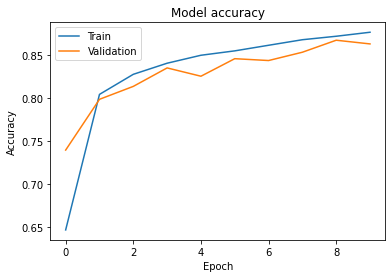

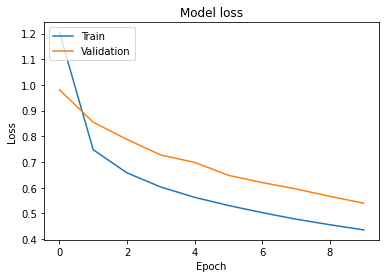

Lenet-5 has max accuracy = 0.8770372


In [14]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print("Lenet-5 has max accuracy = " + str(max(history.history['accuracy'])))

Как видно из значений выше - данная модель обучается медленнее остальных, однако, стоит отметить, что она имеет лучший результат на валидационной выборке, т.е. модель имеет крайне низкую степень переобучения.

Сравнивая все ранее описанные модели, можно отметить, что все они имеют достаточно высокую точность 90%+. Однако так же, они имеют и минус - со временем они начинают переобучаться, особо не помогает даже Dropout. Наиболее хороший результат в этой сфере показывает модель LeNet-5, которую можно отметить за её хорошее удержание переобучения модели.